## Load Spotify API

In [2]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json

In [3]:
with open('./config.json') as f:
    config = json.load(f)
client_id = config['client_id']
client_secret = config['client_secret']
redirect_uri='https://www.google.com/'

In [4]:
username = config['username']
client_creds_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
scope = "user-library-read playlist-read-private"
try:
    token = util.prompt_for_user_token(username, scope, client_id=client_id, 
                                       client_secret=client_secret, redirect_uri=redirect_uri)
    sp = spotipy.Spotify(auth=token)
except:
    print(f'token is not accessible for {username}')

## Grab Data from Spotify API

In [48]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
playlist_dict = {
    "Get Turnt": "37i9dQZF1DWY4xHQp97fN6",
    "Classical Essentials": "37i9dQZF1DWWEJlAGA9gs0", #37i9dQZF1DXaXB8fQg7xif
    "Rock Save the Queen" : "37i9dQZF1DXcDnIr0iKAG8",
    "Coffee Table Jazz" : "37i9dQZF1DWVqfgj8NZEp1"
}
spotify_username = 'Spotify'

In [8]:
# Load the playlists into objects
playlists = [sp.user_playlist(spotify_username, playlist_id=v) for _, v in playlist_dict.items()]

In [9]:
def extract_playlist_info(playlists):
    df_playlists = []
    for playlist in playlists:
        playlist_items = playlist['tracks']['items']
        df_playlist = pd.DataFrame(columns=('song_id', 'song_name', 'song_artist'))
        for item in playlist_items:
            track = item['track']
            df_playlist = df_playlist.append(
                {
                    'song_id': track['id'],
                    'song_name': track['name'],
                    'song_artist': track['artists'][0]['name']
                },
                ignore_index=True
            )
        df_playlists.append(df_playlist)
    return df_playlists

In [10]:
def extract_audio_features(df_playlists):
    df_features_list = []
    columns = ['song_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 
            'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
    for df_playlist in df_playlists:
        song_ids = list(df_playlist['song_id'])
        df_audio_features = pd.DataFrame(data=sp.audio_features(tracks=song_ids))
        
        df_features = df_audio_features[columns[1:]].join(df_playlist['song_name'])
        df_features_list.append(df_features[columns]) # put columns inside to make sure song_name 
                                                      #is the first column.
    return df_features_list

In [11]:
df_playlists = extract_playlist_info(playlists)
df_features_list = extract_audio_features(df_playlists)
df_features_list[0]

,song_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo
0,Going Bad (feat. Drake),0.889,0.496,4,-6.365,0,0.0905,0.259000,0.000000,0.5440,86.003
1,Wow.,0.833,0.539,11,-7.399,0,0.1780,0.163000,0.000002,0.3850,99.947
2,Splashin,0.942,0.383,10,-8.099,1,0.5650,0.001950,0.000000,0.3800,100.021
3,Startender (feat. Offset and Tyga),0.736,0.622,6,-4.653,0,0.1330,0.023500,0.000000,0.5060,191.971
4,Pure Water (with Migos),0.680,0.559,0,-5.545,1,0.1290,0.172000,0.000000,0.1370,202.006
5,Thotiana,0.906,0.382,10,-12.890,0,0.2690,0.180000,0.000000,0.3910,104.025
6,TAlk tO Me (with Rich The Kid feat. Lil Wayne)...,0.698,0.660,0,-7.883,1,0.0520,0.022600,0.000000,0.4510,159.949
7,Crushed Up,0.782,0.599,10,-6.817,0,0.2090,0.037200,0.000000,0.5860,157.999
8,Girls Have Fun (feat. G-Eazy & Rich The Kid),0.888,0.740,8,-5.363,1,0.2380,0.005860,0.000000,0.6640,100.003
9,KIKA (feat. Tory Lanez),0.745,0.715,1,-3.368,0,0.2450,0.128000,0.000000,0.3420,94.513


## Setting up Training Data

In [12]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [13]:
def convert_df_to_array(df):
    converted_list = []
    for _, row in df.iterrows():
        converted_list.append(np.array(list(row[1:])))  # use 1: to avoid adding in song name
    return np.asarray(converted_list)

In [39]:
def create_X_data(df_features_list):
    X = []
    for df_features in df_features_list:
        converted_array = convert_df_to_array(df_features)
        for item in converted_array:
            X.append(item)
    return np.asarray(X)

In [40]:
def create_y_data():
    y = np.array([])
    for i in range(0, 4):
        y = np.append(y, np.ones(shape=(100, 1)) * i)
    return y

In [41]:
X = create_X_data(df_features_list) 
X.shape

(400, 10)

In [42]:
y = to_categorical(create_y_data())
y.shape

(400, 4)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # data set small
                                                                                          # so smaller test size
X_train.shape, y_train.shape

((360, 10), (360, 4))

## Create Model

In [70]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix

In [74]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Model V1

In [45]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [47]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=90, epochs=30)

Epoch 1/30
360/360 [==============================] - 0s 792us/step - loss: 1.3432 - acc: 0.3778
Epoch 2/30
360/360 [==============================] - 0s 29us/step - loss: 1.3899 - acc: 0.3556
Epoch 3/30
360/360 [==============================] - 0s 49us/step - loss: 1.3250 - acc: 0.3917
Epoch 4/30
360/360 [==============================] - 0s 55us/step - loss: 1.3488 - acc: 0.3833
Epoch 5/30
360/360 [==============================] - 0s 46us/step - loss: 1.3153 - acc: 0.3833
Epoch 6/30
360/360 [==============================] - 0s 42us/step - loss: 1.2965 - acc: 0.4083
Epoch 7/30
360/360 [==============================] - 0s 52us/step - loss: 1.3041 - acc: 0.3861
Epoch 8/30
360/360 [==============================] - 0s 35us/step - loss: 1.3669 - acc: 0.3917
Epoch 9/30
360/360 [==============================] - 0s 59us/step - loss: 1.3670 - acc: 0.3889
Epoch 10/30
360/360 [==============================] - 0s 33us/step - loss: 1.3550 - acc: 0.3667
Epoch 11/30
360/360 [=================

In [76]:
model.evaluate(X_test, y_test, batch_size=90)

40/40 [==============================] - 0s 968us/step


[1.2115564346313477, 0.44999998807907104]

In [66]:
y_pred = model.predict(X_test)
y_pred

array([[ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.25713977,  0.23461829,  0.25440991,  0.25383201],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.00268208,  0.7707898 ,  0.00245204,  0.22407609],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.20810698,  0.31221068,  0.18708426,  0.29259804],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.25212696,  0.24187399,  0.24700922,  0.25898978],
       [ 0.26248315,  0.22814754,  0.26306802,  0.24630126],
       [ 0.26248315,  0.

Confusion matrix, without normalization
[[ 1  0 11  0]
 [ 1  6  1  1]
 [ 0  0 11  0]
 [ 1  6  1  0]]


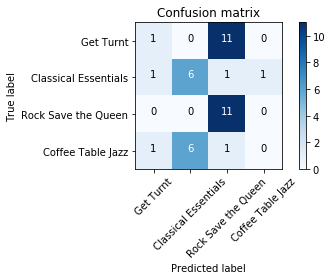

In [79]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()

Looking at this confusion matrix, I notice 3 things.
1. Testing dataset is very small. I need to expand my total data set
2. Coffee table jazz and Get Turnt are not being classfied correctly. Exploration is needed to see why
3. Rock save the queen is doing quite well. Exploration is needed to see why.

## Exploration

In [ ]:
# tbc...